# Problem 1 - Newton's Method Implementation

In [52]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [53]:
Nel  = 500
mesh = UnitIntervalMesh(Nel)
V    = FunctionSpace(mesh, "CG", 1)
u    = Function(V)
v    = TestFunction(V)
x    = SpatialCoordinate(mesh)
F    = ((u+1)**2) * inner(grad(u), grad(v))*dx + (u*u + u)*v*dx - sin(pi*x[0])*v*dx

du   = TrialFunction(V)
J    = derivative(F, u, du)

solve(F==0,u,[])

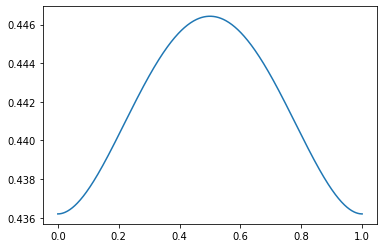

In [54]:
xvec = np.linspace(0,1,Nel+1)
plt.plot(xvec, u.compute_vertex_values())

i.e. we are trying to find $u\in V_h$ such that

$$F(u;v) = \int_\Omega (u+1)^2 u' v' \, d\Omega + \int_\Omega (u^2+u)v \,d\Omega - \int_\Omega \sin(\pi x) v \, d\Omega = 0 ~~~~~~\forall v \in V_h$$ 

### 1a)

The equivalent strong form can be derived as follows:

First we use integration by parts on the first term; we note that the absence of boundary integral terms in $F(u;v)$ as well as no use of "dolfin.DirichletBC()" (i.e. strong enforcement) or a penalty term (weak enforcement) implies that the boundary conditions are homogeneous Neumann ($\frac{du}{dn}=0 ~~\text{on}~~ \partial\Omega$).

$$\int_\Omega (u+1)^2 u' v' \, d\Omega = \int_\Omega \left[-(u+1)^2 u'' - 2(u+1)u'^2 \right] v \, d\Omega$$

Plugging this result into $F(u;v)$ gives,

$$\int_\Omega (u+1)\left[ -(u+1) u'' - 2u'^2 + u \right]v - \sin(\pi x)v \, d\Omega$$

since $v$ is an arbitrary test function this result must hold for any $v \in V^h$ thus we can express the strong form as:

$$\boxed{(u+1)\left[ -(u+1) u'' - 2u'^2 + u \right] = \sin(\pi x)}$$
with homogeneous Neumann boundary condition
$$\boxed{\frac{du}{dn}=0 ~~\text{on}~~ \partial\Omega}$$

### 1b)

The intuition for Newton's method can easily be shown through a Taylor expansion of $F(u;v)$ around our current estimate of $u$. For notational simplicity we will ignore the dependence of $F(u;v)$ on $v$ as we are only differentiating with respect to $u$ and $v$ is an arbitrary test function anyways. We will refer to $u^n$ as the current estimate of $u$; the next approximation of $u$ will be referred to as $u^{n+1}$. $\delta u \equiv u^{n+1} - u^{n}$ is the scalar/vector we must travel to get from our current estimate of $u$ to the new estimate. Since we are searching for the root of $F(u)$, it is natural to assume $F(u^{n+1})=0$.

$$F(u^n + \delta u) = F(u^n) + \frac{\partial F}{\partial u} (u^n) \delta u + \mathcal{O}(\delta u ^2) = 0$$
in the limit as $\delta u \rightarrow 0$ we can ignore the higher order terms
$$\boxed{\frac{-\partial F(u^n)}{\partial u} \delta u = F(u^n)}$$

i.e. at each iteration we solve the linear system where the Jacobian of $F$ is the left-hand-side matrix and $F$ is the right-hand-side vector; the solution gives us $\delta u$, and the new value of $u$ can be found simply by $u^{n+1} = u^n + \delta u$.

The implementation in FEniCS is as follows:

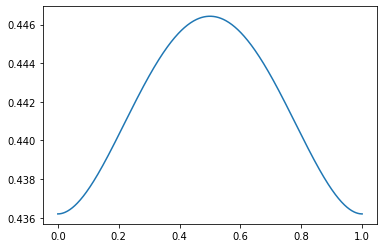

In [55]:
u     = Function(V) # u^{n+1}
F     = ((u+1)**2) * inner(grad(u), grad(v))*dx + (u*u + u)*v*dx - sin(pi*x[0])*v*dx

J     = derivative(F, u)
niter = 5

uv    = u.vector()
#plt.plot(xvec, uv.get_local(), label='initial')

for idx in range(niter):
    # just so that we are very explicit in what is actually happening let's assemble the linear system
    # as numpy matrices and solve through an external module (scipy) instead of using dolfin.solve()
    A     = assemble(-J).array()      # Ndof x Ndof matrix
    L     = assemble(F).get_local()   # Ndof x 1 vector
    
    # Instead of the lines below, one could equivalent use u = dolfin.solve(A,L,u)
    Asp   = sp.csc_matrix(A)          # "compressed sparse column". Like many FE methods the lhs matrix is typically very sparse
    du    = spla.spsolve(Asp,L)       # cast as a scipy sparse matrix type
    uv.set_local(uv.get_local() + du) # assign newly computed solution

plt.plot(xvec, uv.get_local())


### 1c)

Let's implement the Newton method on the same problem by computing the Gateaux derivative of $F$ manually...

$$\begin{align} 
J(u;v) &= \lim_{\varepsilon \to 0} \frac{d}{d\varepsilon} F(u^n + \varepsilon \delta u; v) \\
&= \lim_{\varepsilon \to 0} \frac{d}{d\varepsilon} \int_\Omega (u+1)^2 u' v' + (u^2+u)v  - \sin(\pi x) v \, d\Omega \\
&= \lim_{\varepsilon \to 0} \frac{d}{d\varepsilon} \int_\Omega (u^n+\varepsilon \delta u+1)^2 (u^n+\varepsilon \delta u)' v' + (u^n+\varepsilon \delta u)(u^n+\varepsilon \delta u+1)v  - \sin(\pi x) v \, d\Omega \\
&= \lim_{\varepsilon \to 0} \int_\Omega 2(u^n+\varepsilon \delta u+1) \delta u (u^n+\varepsilon \delta u)' v' + (u^n+\varepsilon\delta u + 1)^2 \delta u' v' + \delta u (u^n + \varepsilon \delta u + 1)v + \delta u (u^n + \varepsilon \delta u)v\, d\Omega \\
&= \int_\Omega 2(u^n+1) \delta u (u^n)' v' + (u^n+1)^2 \delta u' v' + \delta u (2u^n+1)v \, d\Omega 
\end{align}$$

In [56]:
u      = Function(V) # u^{n}
v      = TestFunction(V)
du     = TrialFunction(V)
J      = (2*(u+1)*du*inner(grad(u),grad(v)) + (u+1)**2*inner(grad(du),grad(v)) + du*(2*u+1)*v)*dx
F      = ((u+1)**2) * inner(grad(u), grad(v))*dx + (u*u + u)*v*dx - sin(pi*x[0])*v*dx
du     = Function(V)

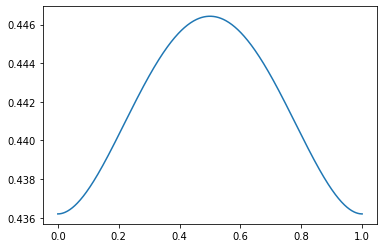

In [57]:
niter = 5 # number of newton iterations

for idx in range(niter):
    # just so that we are very explicit in what is actually happening let's assemble the linear system
    # as numpy matrices and solve through an external module (scipy) instead of using dolfin.solve()
    A     = assemble(-J)      # Ndof x Ndof matrix
    L     = assemble(F)       # Ndof x 1 vector
    solve(A,du.vector(),L)
    u.assign(u+du)    

plt.plot(xvec, u.vector().get_local())

# Problem 2 - Method of Manufactured Solutions

We will manufacture the RHS, $f(x)$, by assuming the solution $u(x)= \sin(\pi x)$ and plugging into the PDE:

$$
\begin{align}
-\left( \left(u^2+1 \right) u' \right)' &= f ~~~~~~~~\forall x \in (0,1) \\
u(0) &= u(1) = 0
\end{align}
$$


$$
\begin{align}
f &= -\left( \left(\sin^2(\pi x)+1 \right) \pi \cos(\pi x) \right)' \\
&= -\pi^2 \left( - \sin(\pi x) -\sin^3(\pi x) + 2 \sin(\pi x) \cos^2(\pi x) \right) \\
&= (-\pi^2 \sin(\pi x)) \left(-1 - \sin^2(\pi x) + 2 \cos^2(\pi x) \right) \\
&= (-\pi^2 \sin(\pi x)) \left(-1 - 2\sin^2(\pi x) + (\sin^2(\pi x) + \cos^2{\pi x}) + \cos^2{\pi x} \right) \\
&= (-\pi^2 \sin(\pi x)) \left(- 2\sin^2(\pi x) + \cos^2(\pi x) \right) \\
&= \boxed{(-\pi^2 \sin(\pi x)) \left(3\sin^2(\pi x) + 1 \right)} \\
\end{align}
$$

In [58]:
Nelvec = [2**x for x in range(2,10)]
H1err  = [0]*len(Nelvec)
for idx, Nel in enumerate(Nelvec):
    mesh = UnitIntervalMesh(Nel)
    x    = SpatialCoordinate(mesh)
    V    = FunctionSpace(mesh, "CG", 1)
    v    = TestFunction(V)
    usol = sin(pi*x[0])
    f    = -div((usol**2+1)*grad(usol))

    u = Function(V)
    v = TestFunction(V)
    F = (inner((u**2+1)*grad(u), grad(v)) - f*v)*dx
    def boundary_ends(x, on_boundary):
        return on_boundary and (near(x[0],0) or near(x[0],1))
    bc = DirichletBC(V, Constant(0.0), boundary_ends)
    solve(F==0, u, bcs=bc)
    H1err[idx] = sqrt(assemble(((u - usol)**2 + (grad(u) - grad(usol))**2)*dx))

Convergence rate (fitted) of the error in the H1 norm is 0.9989593848813509 (1 is optimal)


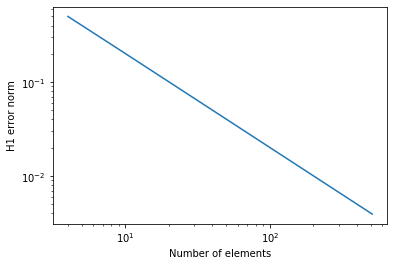

In [59]:
# Plot errors
plt.loglog(Nelvec,H1err)
plt.xlabel('Number of elements')
plt.ylabel('H1 error norm')
slope, _ = np.polyfit(np.log(Nelvec), np.log(H1err), 1)
print(f"Convergence rate (fitted) of the error in the H1 norm is {-slope} (1 is optimal)")

# Problem 3 - Heat Conduction

### 3a)

$$
\begin{align}
\partial_t u(x,t) &= \nabla^2 u(x,t) + f(u) ~~~~\text{in}~~~~ \Omega \\
u(x,t) &= 0 ~~~~\text{on}~~~~ \partial\Omega \\
u(x,t=0) &= 0 ~~~~\text{in}~~~~~ \Omega
\end{align}
$$

$f(u)$ is chosen such that the PDE is satisfied exactly when $u(x,t)=\sin(t) \sin(\pi x)$ (method of manufactured solutions)

### 3b)

We solve the above system using the trapezoidal/Crank-Nicholson integration rule

In [178]:
def solve_for_Nel(Nel, function_space_order=1, time_int_alpha=0.5):
    C = 1
    N = C*Nel # number of timesteps
    Tfinal = 1.0
    dt = Constant(Tfinal/N)
    mesh = UnitIntervalMesh(Nel)
    x = SpatialCoordinate(mesh)
    V = FunctionSpace(mesh, "CG", function_space_order)

    u = TrialFunction(V)
    uold = Function(V)
    v = TestFunction(V)
    t = Constant(dt)
    told = Constant(0.0)
    u_t = (u-uold)/dt

    # manufactured RHS
    usol   = lambda t: sin(t) * sin(pi * x[0])
    usol_t = lambda t: cos(t) * sin(pi * x[0])
    f      = lambda t: usol_t(t) - div(grad(usol(t)))

    # # bilinear, linear forms
    F = (u_t*v + alpha*(inner(grad(u), grad(v)) - f(t)*v) + (1-alpha)*(inner(grad(uold), grad(v)) - f(told)*v))*dx
    a, L = lhs(F), rhs(F)
    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    u = Function(V)

    for idx in range(N):
        solve(a==L, u, bcs=bc)
        uold.assign(u)
        t.assign(t+dt)
        told.assign(told+dt)
    
    return {"L2": sqrt(assemble((u-usol(told))**2*dx)), "H1semi": sqrt(assemble(((grad(u)-grad(usol(told)))**2*dx)))}

### 3c) and 3d)

Verification that L2 error converges at rate two

In [179]:
Nelvec = [x**2 for x in range(2,10)]
err = {}
for alpha in [0.5, 1.0]: # generalized trapezoidal rule parameter
    for CG_order in [1, 2]:
        err[(alpha, CG_order, "L2")] = []
        err[(alpha, CG_order, "H1semi")] = []
        for Nel in Nelvec:
            temp = solve_for_Nel(Nel, function_space_order=CG_order, time_int_alpha=alpha)
            err[(alpha, CG_order, "L2")].append(temp["L2"])
            err[(alpha, CG_order, "H1semi")].append(temp["H1semi"])

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Plot

alpha=0.5, CG1: Convergence rate (fitted) of the error in the H1 semi norm is 0.9972392226151334
alpha=0.5, CG2: Convergence rate (fitted) of the error in the H1 semi norm is 1.9976003325023297
alpha=1.0, CG1: Convergence rate (fitted) of the error in the H1 semi norm is 0.9969442241638923
alpha=1.0, CG2: Convergence rate (fitted) of the error in the H1 semi norm is 1.22493407445725


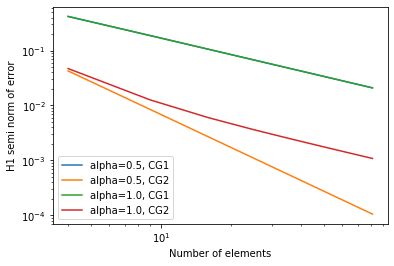

In [188]:
for alpha in [0.5, 1.0]: # generalized trapezoidal rule parameter
    for CG_order in [1, 2]:
        plt.loglog(Nelvec, err[(alpha,CG_order,"H1semi")], label=f'alpha={alpha}, CG{CG_order}')
        slope, _ = np.polyfit(np.log(Nelvec), np.log(err[(alpha,CG_order,"H1semi")]), 1)
        print(f"alpha={alpha}, CG{CG_order}: Convergence rate (fitted) of the error in the H1 semi norm is {-slope}")
plt.xlabel('Number of elements')
plt.ylabel('H1 semi norm of error')
plt.legend()

In both cases where the discretization was over CG2, the errors not only had a smaller intercept but a steeper slope. Since Crank-Nicholson is second order compared to backward Euler which is first, we see that it converges more rapidly in th H1 seminorm. Convergence rates can depend on the regularity of the mesh, which is one possibility for the non-integer convergence rate of CG1 using backward Euler.

# Problem 4 - Coupled PDEs

### 4a)

The problem described is steady heat conduction (i.e.~the Poisson equation) coupled one-way to linear elastostatics via thermal expansion in the strain term. We define the strain, hydrostatic strain, and stress as such (note that we use the comma notation to indicate a partial derivative with respect to an index)

$$
\begin{align}
\varepsilon_{ij} &= u_{(i,j)} - \alpha T \delta_{ij}= \frac12 (u_{i,j} + u_{j,i}) - \alpha T \delta_{ij} \\
\text{tr} \varepsilon_{ij} &= \varepsilon_{kk} = p = 3u_{i,i} - 3 \alpha T \\
\sigma_{ij} &= K p \delta_{ij} + 2 G \left(\varepsilon_{ij} - \frac{p}{3} \delta_{ij}\right)
\end{align}
$$

Now we convert the weak form into the strong form

$$
\begin{align}
a(\sigma, T ; v, Q) &= L(f,v) 
\end{align}
$$


$$
\begin{align}
a &= (\sigma_{ij} ~,~ v_{i,j}) + (kT_{,i} ~,~  Q_{,i}) \\
&= -(\sigma_{ij,j} ~,~ v_i) - (kT_{,ii} ~,~  Q) \\
L &= (f_i ~,~ v_i)
\end{align}
$$


Under the argument that $v_i$ and $Q$ are arbitrary test functions, we can derive the strong forms,
$$
\begin{align}
-\sigma_{ij,j} &= f_i  ~~~~\text{in}~~~~ \Omega \\
u_0 &= 0 ~~~~\text{on}~~~~ \partial\Omega \cap (x_0=0) \\
u_1 &= 0 ~~~~\text{on}~~~~ \partial\Omega \cap (x_1=0) \\
u_2 &= 0 ~~~~\text{on}~~~~ \partial\Omega \cap (x_2=0) \\
\sigma_{ij} n_j &= 0 ~~~~\text{else}~~~
\end{align}
$$
where $n_j$ is the unit normal vector.

$$
\begin{align}
-k\nabla^2 T &= 0 ~~~~\text{in}~~~~ \Omega \\
T &= 0 ~~~~\text{on}~~~~ \partial\Omega \cap (x_0=0) \\
T &= 1 ~~~~\text{on}~~~~ \partial\Omega \cap (x_1=0) \\
\nabla T \cdot \mathbf{n} &= 0 ~~~~\text{on}~~~~ \partial\Omega \\
\end{align}
$$


### 4b)

Original code...

In [198]:
from dolfin import *
N = 16
mesh = UnitCubeMesh(N,N,N)
d = mesh.geometry().dim()
cell = mesh.ufl_cell()
uE = VectorElement("CG", cell, 1)
TE = FiniteElement("CG", cell, 1)
V = FunctionSpace(mesh, MixedElement([uE,TE]))
def b0(x, on_boundary):
    return on_boundary and near(x[0],0)
def b1(x, on_boundary):
    return on_boundary and near(x[1],0)
def b2(x, on_boundary):
    return on_boundary and near(x[2],0)
bcu0 = DirichletBC(V.sub(0).sub(0), Constant(0), b0)
bcu1 = DirichletBC(V.sub(0).sub(1), Constant(0), b1)
bcu2 = DirichletBC(V.sub(0).sub(2), Constant(0), b2)
bcT0 = DirichletBC(V.sub(1), Constant(0), b0)
bcT1 = DirichletBC(V.sub(1), Constant(1), b1)
u,T = TrialFunctions(V)
v,Q = TestFunctions(V)
K = Constant(1)
G = Constant(1)
alpha = Constant(1)
I = Identity(d)
eps = sym(grad(u)) - alpha*I*T
sigma = K*tr(eps)*I + 2*G*(eps-tr(eps)*I/3)
f = Constant(d*(0,))
k = Constant(1)

a = inner(sigma, grad(v))*dx + dot(k*grad(T),grad(Q))*dx
L = inner(f,v)*dx
uTh = Function(V)
solve(a==L,uTh, [bcu0, bcu1, bcu2, bcT0, bcT1])
uout, Tout = uTh.split()
File("u.pvd") << uout
File("T.pvd") << Tout

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Modified code to solve problems separately...

In [215]:
from dolfin import *
N = 16
mesh = UnitCubeMesh(N,N,N)
d = mesh.geometry().dim()
Vu = VectorFunctionSpace(mesh, "CG", 1, dim=d)
VT = FunctionSpace(mesh, "CG", 1)
def b0(x, on_boundary):
    return on_boundary and near(x[0],0)
def b1(x, on_boundary):
    return on_boundary and near(x[1],0)
def b2(x, on_boundary):
    return on_boundary and near(x[2],0)
bcu0 = DirichletBC(Vu.sub(0), Constant(0), b0)
bcu1 = DirichletBC(Vu.sub(1), Constant(0), b1)
bcu2 = DirichletBC(Vu.sub(2), Constant(0), b2)
bcT0 = DirichletBC(VT, Constant(0), b0)
bcT1 = DirichletBC(VT, Constant(1), b1)

K = Constant(1)
G = Constant(1)
alpha = Constant(1)
I = Identity(d)
f = Constant(d*(0,))
k = Constant(1)

# First we solve the steady-state heat conduction problem...
Th = Function(VT)
Q = TestFunction(VT)
aT = dot(k*grad(Th),grad(Q))*dx
solve(aT==0, Th, [bcT0, bcT1])

# Use solution to solve thermally dependent elastostatic problem
u = Function(Vu)
v = TestFunction(Vu)
eps = sym(grad(u)) - alpha*I*Th
sigma = K*tr(eps)*I + 2*G*(eps-tr(eps)*I/3)
Fu = -inner(sigma, grad(v))*dx + inner(f,v)*dx
solve(Fu==0, u, [bcu0,bcu1,bcu2])

File("u_v2.pvd") << u
File("T_v2.pvd") << Th

Check that solution is the same...

In [243]:
err_L2_u = sqrt(assemble((u - project(uout,Vu))**2*dx))
err_L2_T = sqrt(assemble((Th - project(Tout,VT))**2*dx))
print(f"L2 errors...\nu: {err_L2_u}\nT: {err_L2_T}")

L2 errors...
u: 6.47649088484677e-15
T: 7.382412715068178e-15


### 4c)

See attached image of temperature field visualized in false color with the displacement field visualized by mesh distortions.